# **LOAD LIBRARIES**

In [6]:
!pip install torchaudio -q --no-deps
!pip install speechbrain -q
!pip install spectralcluster -q
!pip install pyannote.metrics -q
!pip install gdown -q

In [7]:
!gdown --id 1rUDuxPTqMMj-lH7Y9W14BgTxkyiVTntX
!unzip core.zip

Downloading...
From: https://drive.google.com/uc?id=1XltkNas1LTOck62GIDYT0WcPDPGZEo7P
To: /content/utils.py
100% 16.8k/16.8k [00:00<00:00, 28.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FWIRF2Kq6JB0fFHwjkZmVfEuGq0-SSC5
To: /content/DEC.py
100% 10.1k/10.1k [00:00<00:00, 8.78MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hbepzjAxHTQS5QoAlKNP9zK0nMxdjauJ
To: /content/optimumSpeaker.py
100% 7.08k/7.08k [00:00<00:00, 4.29MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RQkezkiXa5DVFHE7g4UKE2v8vcmgJFpm
To: /content/baselineMethods.py
100% 4.39k/4.39k [00:00<00:00, 3.47MB/s]


In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import os
import torch
from torch.utils.data import Dataset, DataLoader
from speechbrain.pretrained import SpeakerRecognition
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, SpectralClustering
from sklearn import decomposition
from tqdm.auto import tqdm

from core.utils import DiarizationDataSet, get_metrics, plot_annot
import core.baselineMethods as baselineMethods
from core.DEC import diarizationDEC

import shutil
import pandas as pd

# Download dataset

In [10]:
audio_dataset = DiarizationDataSet(dataset_name='ami',
                                   window_len=1500, 
                                   window_step=750,
                                   use_oracle_vad=True)

print("\nData size:", len(audio_dataset))

Dataset already downloaded!


Downloading...
From: https://drive.google.com/uc?id=1Hzhks79Mq9py0yPfxI_e73Nx5M-XbJp6
To: /content/tmp.zip
100%|██████████| 44.0k/44.0k [00:00<00:00, 26.2MB/s]


Download and Extraction Complete
Precomputed X-vectors exists!
Will use precomputed features...



Downloading...
From: https://drive.google.com/uc?id=1HjW9caW9f3Bqp2hvz97tvLPEz_fFv01X
To: /content/tmp.zip
31.0MB [00:00, 201MB/s]


Download and Extraction Complete

Data size: 16


# Spectral - EigenGap

In [11]:
hypothesis_dir_spectral = baselineMethods.diarizationEigenGapNumSpkrs(audio_dataset, hypothesis_dir="./rttm_output_spectral/")
metric_spectral = get_metrics(audio_dataset.label_dir, hypothesis_dir_spectral)

# DEC

In [12]:
hypothesis_dir_dec = diarizationDEC(audio_dataset, hypothesis_dir="./rttm_output_dec/")
metric_dec = get_metrics(audio_dataset.label_dir, hypothesis_dir_dec)

# Compare

In [13]:
df_dec = metric_dec.report()
df_spectral = metric_spectral.report()

df_spectral = df_spectral[[df_dec.keys()[0]]]
df_dec = df_dec[[df_dec.keys()[0]]]

df_both = df_dec
df_both["DER (Spectral)"] = df_spectral[[df_dec.keys()[0]]]
df_both.columns = ["DER (DEC)", "DER (Spectral)"]

df_both["DER Difference"] = df_both["DER (Spectral)"]-df_both["DER (DEC)"]

df_both = df_both[:-1]
df_both = df_both.sort_values(by=['DER Difference'])

In [14]:
df_dec[-1:]

,DER (DEC),DER (Spectral),DER Difference
item,,,
TOTAL,13.136877,14.961229,1.824352


In [15]:
df_both

,DER (DEC),DER (Spectral),DER Difference
item,,,
IS1009a,40.505644,27.827065,-12.678579
TS3003c,9.313898,8.689440,-0.624457
TS3003a,19.346016,19.346016,0.000000
ES2004a,13.617823,13.627691,0.009869
EN2002c,10.733794,10.837061,0.103267
IS1009b,6.512912,6.879391,0.366479
TS3003d,26.203707,26.602833,0.399126
ES2004b,8.212175,8.714347,0.502172
ES2004c,8.296036,8.873851,0.577816


In [16]:
print("Better DER for", np.sum(df_both['DER Difference'].values>0), "examples.")
print("Poor DER for", np.sum(df_both['DER Difference'].values<0), "examples.")
print("Same DER for", np.sum(df_both['DER Difference'].values==0), "examples.")

Better DER for 13 examples.
Poor DER for 2 examples.
Same DER for 1 examples.


In [17]:
filenames = ["EN2002c"] + list(df_both.index[[-1, -2, -3, 2, 1, 0]])


---------------------------
DEC
---------------------------



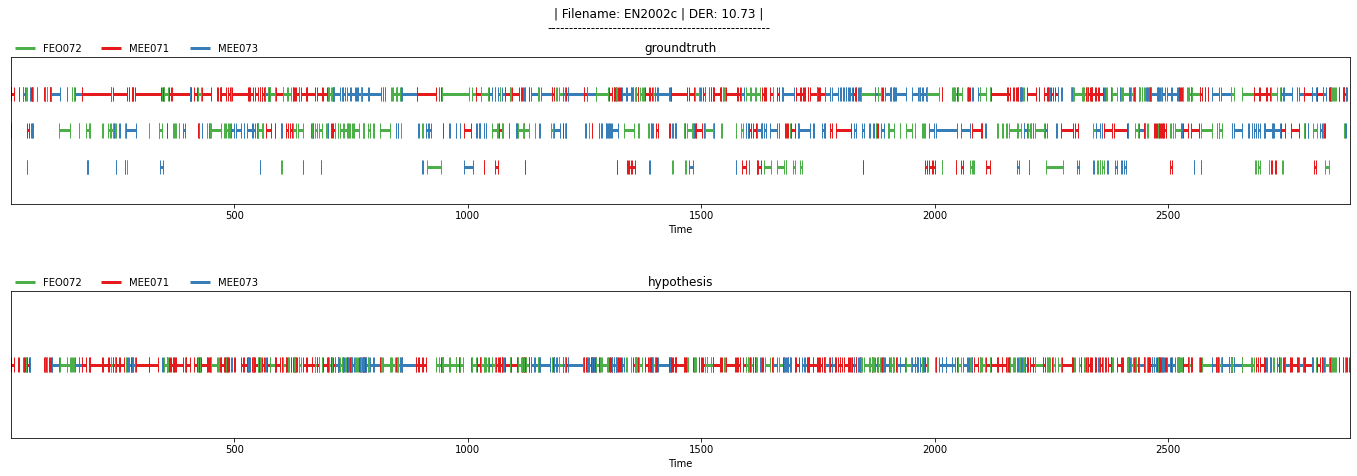


---------------------------
Spectral
---------------------------



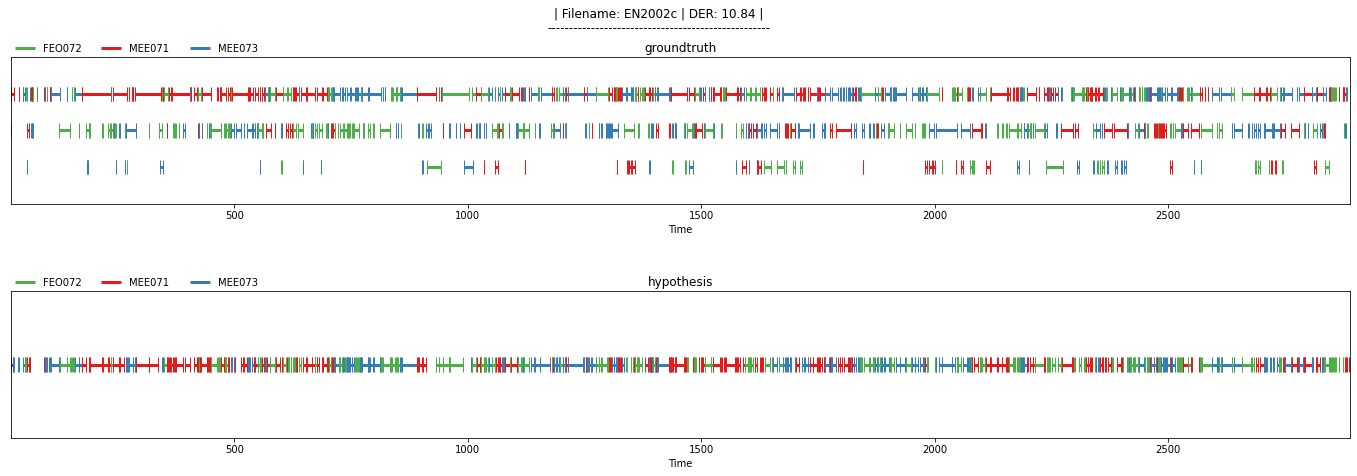


---------------------------
DEC
---------------------------



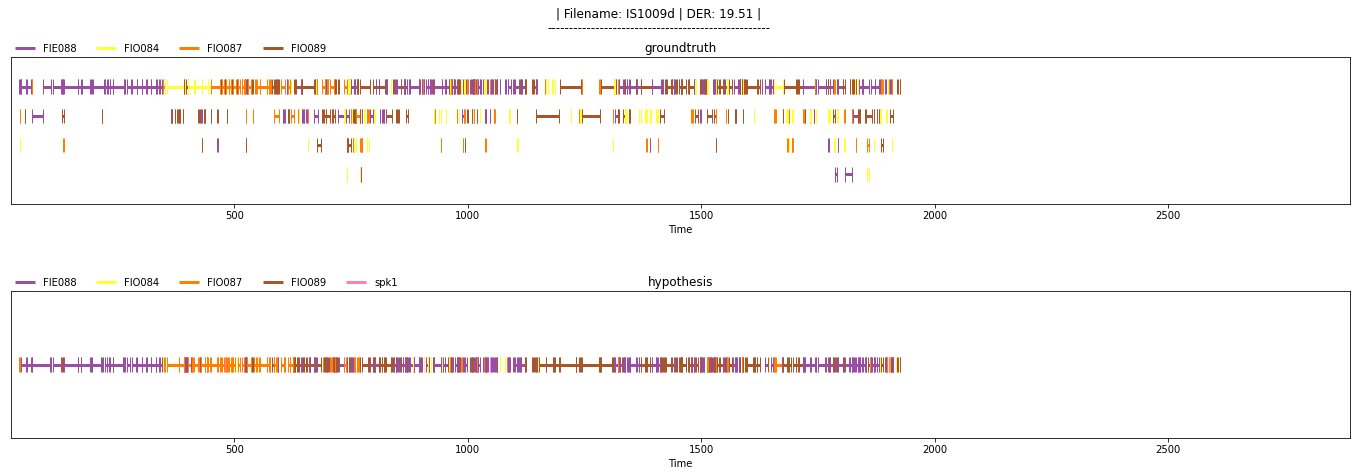


---------------------------
Spectral
---------------------------



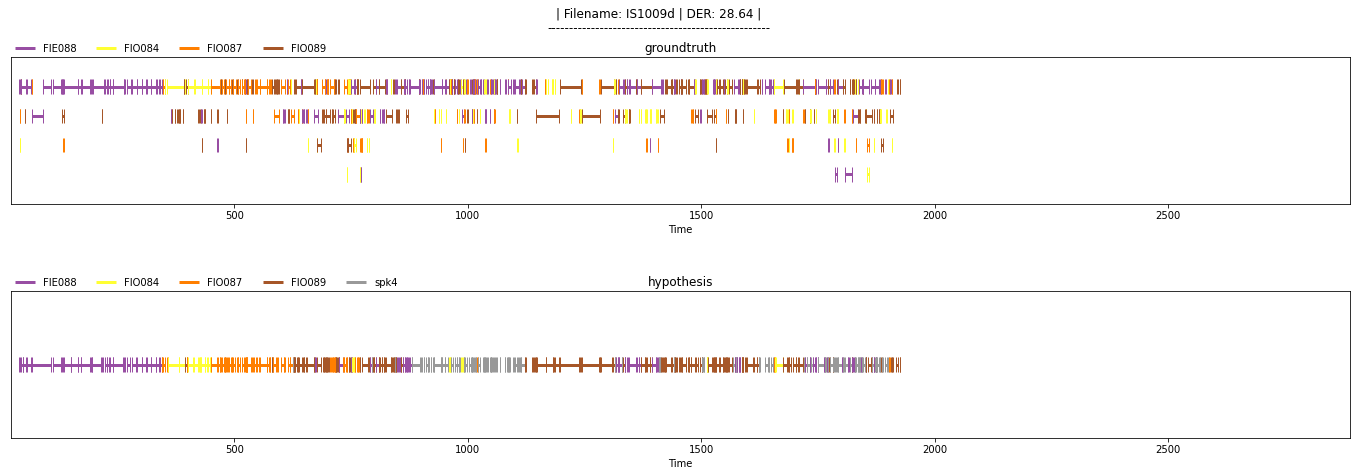


---------------------------
DEC
---------------------------



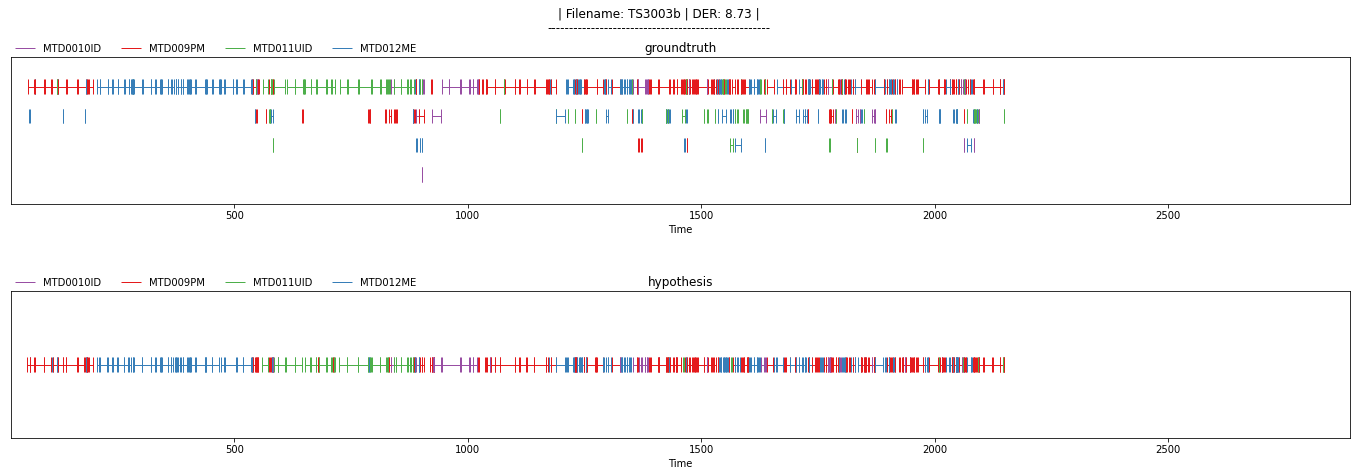


---------------------------
Spectral
---------------------------



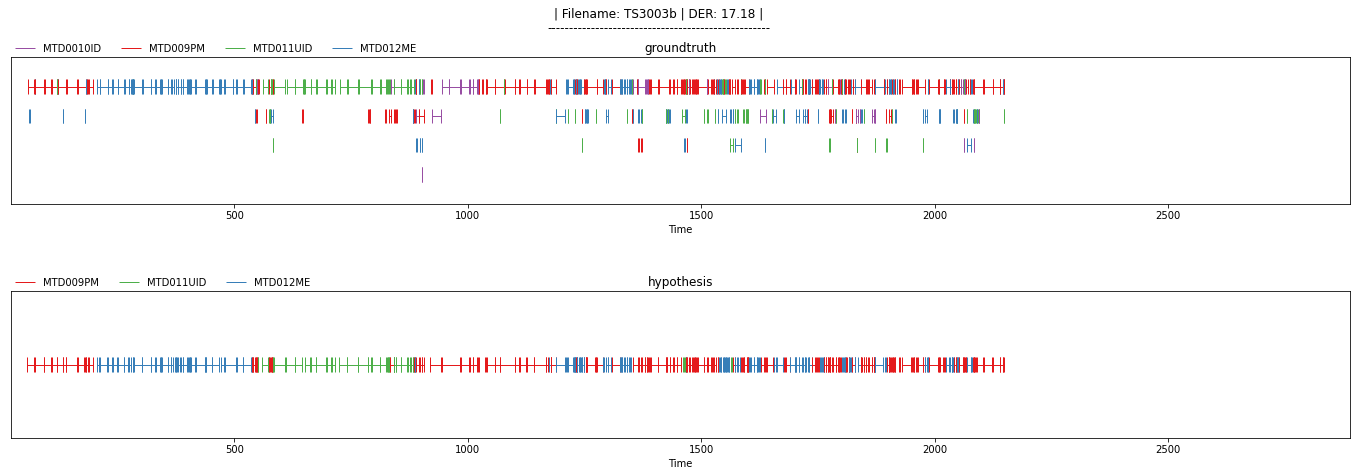


---------------------------
DEC
---------------------------



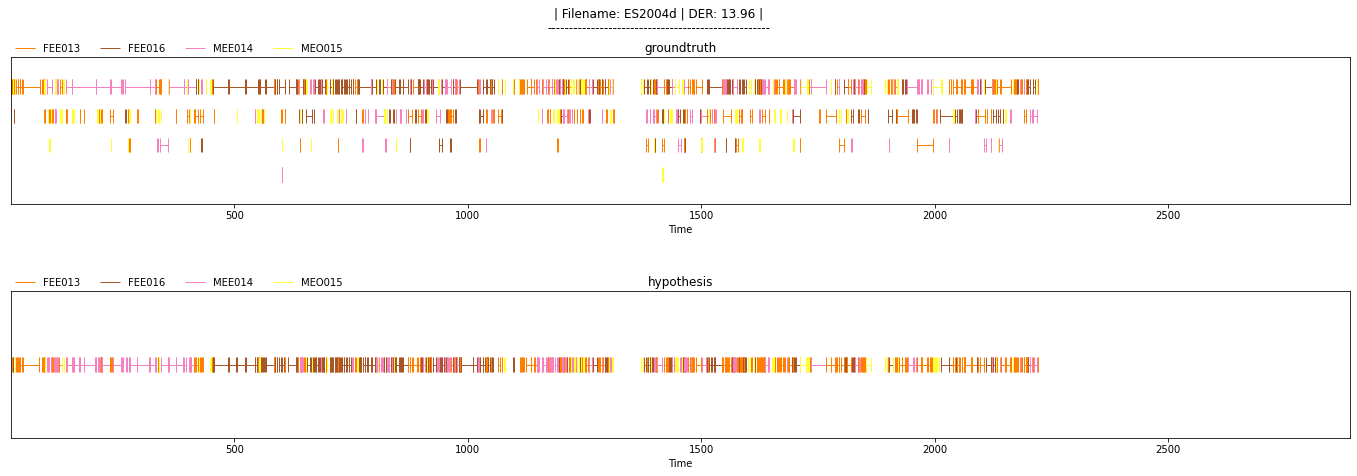


---------------------------
Spectral
---------------------------



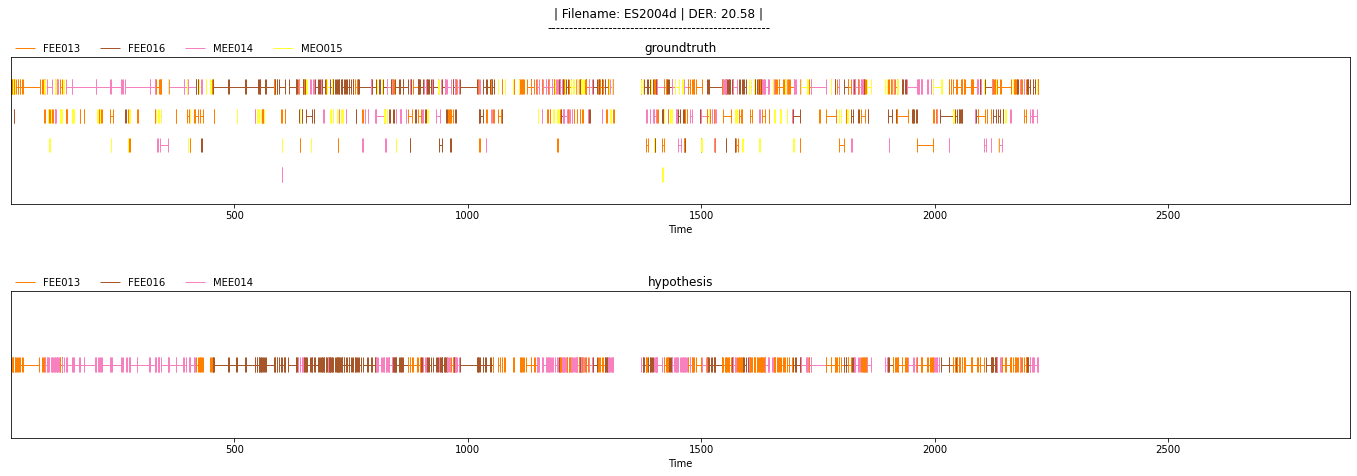


---------------------------
DEC
---------------------------



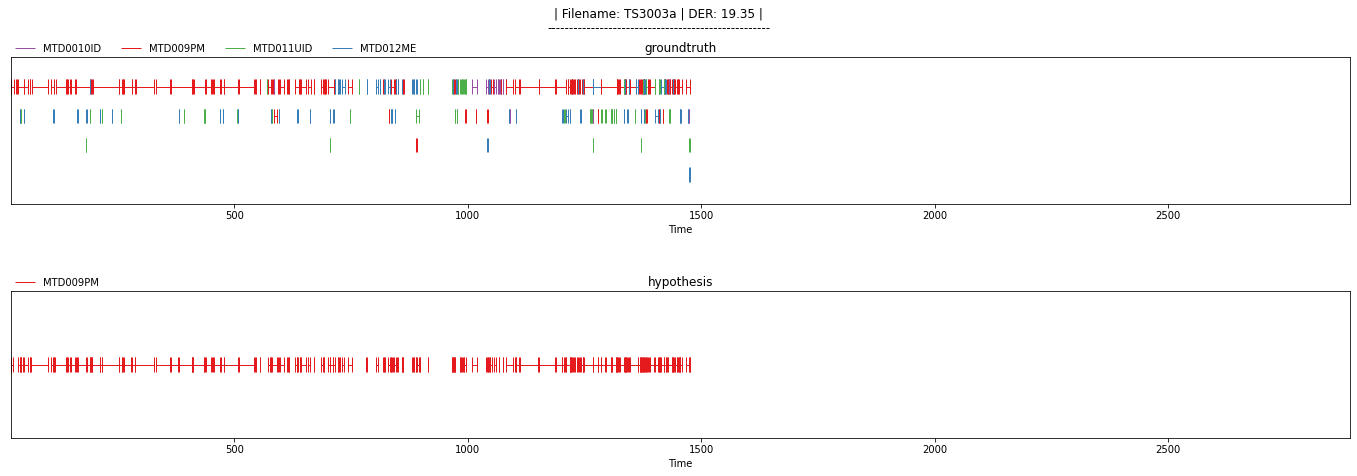


---------------------------
Spectral
---------------------------



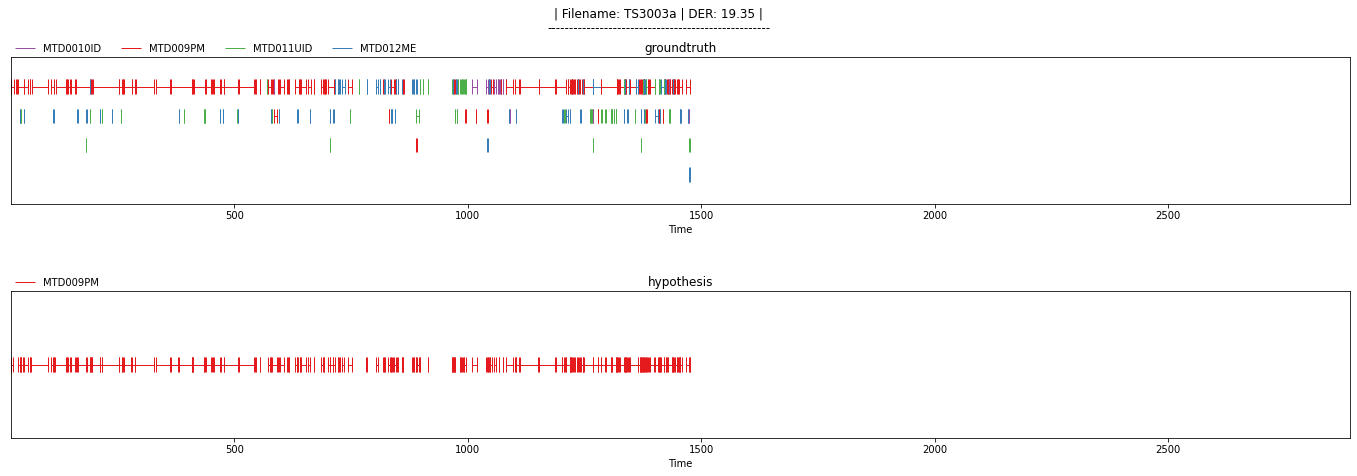


---------------------------
DEC
---------------------------



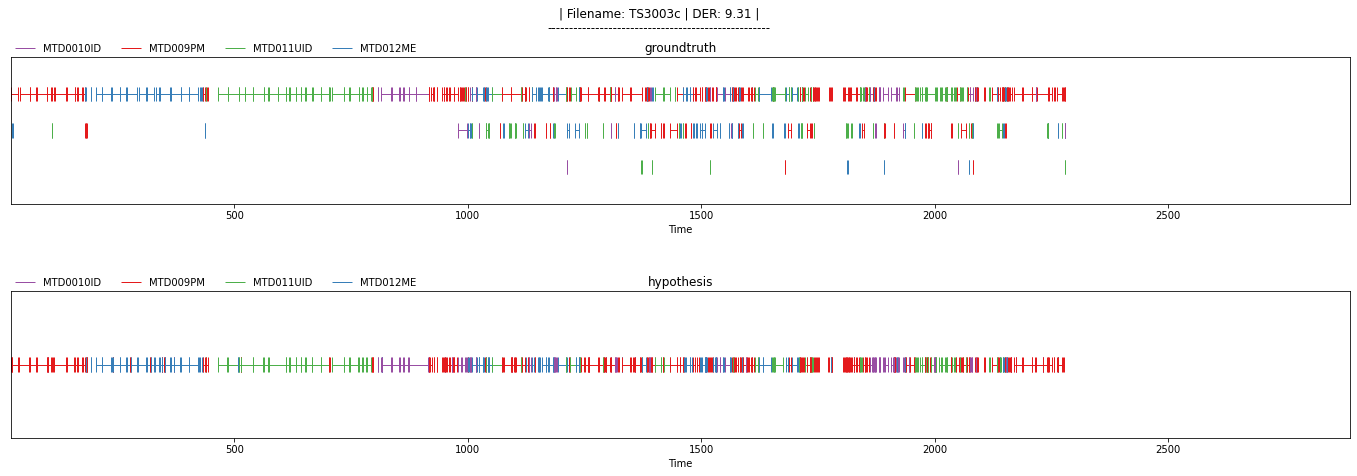


---------------------------
Spectral
---------------------------



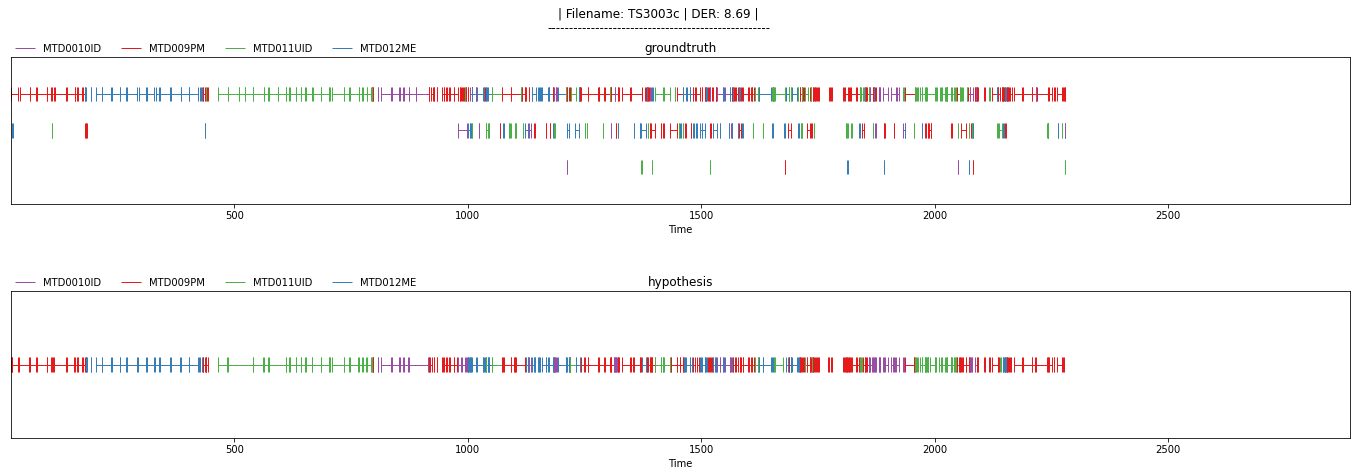


---------------------------
DEC
---------------------------



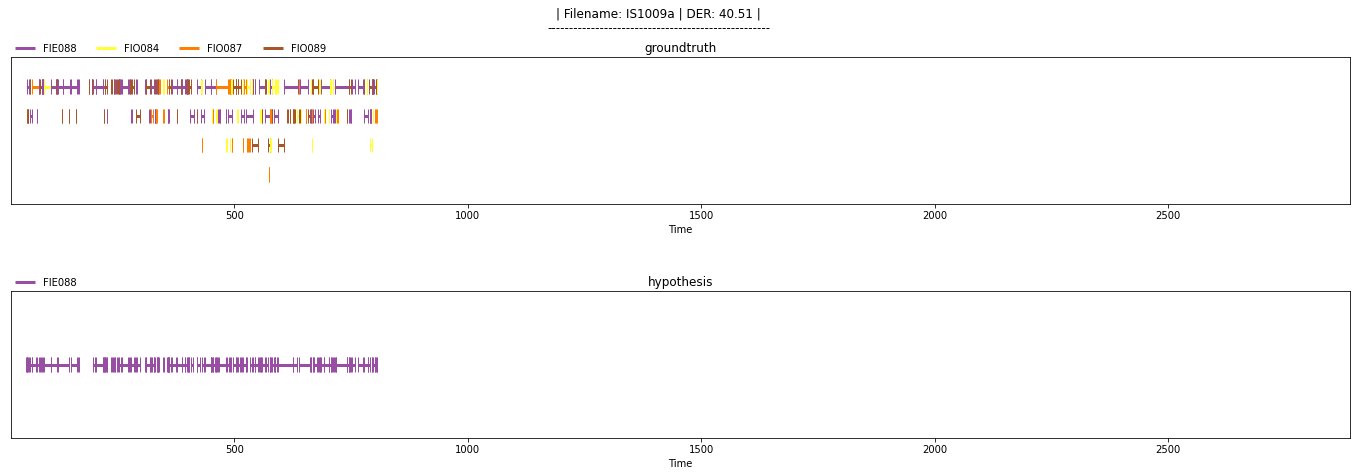


---------------------------
Spectral
---------------------------



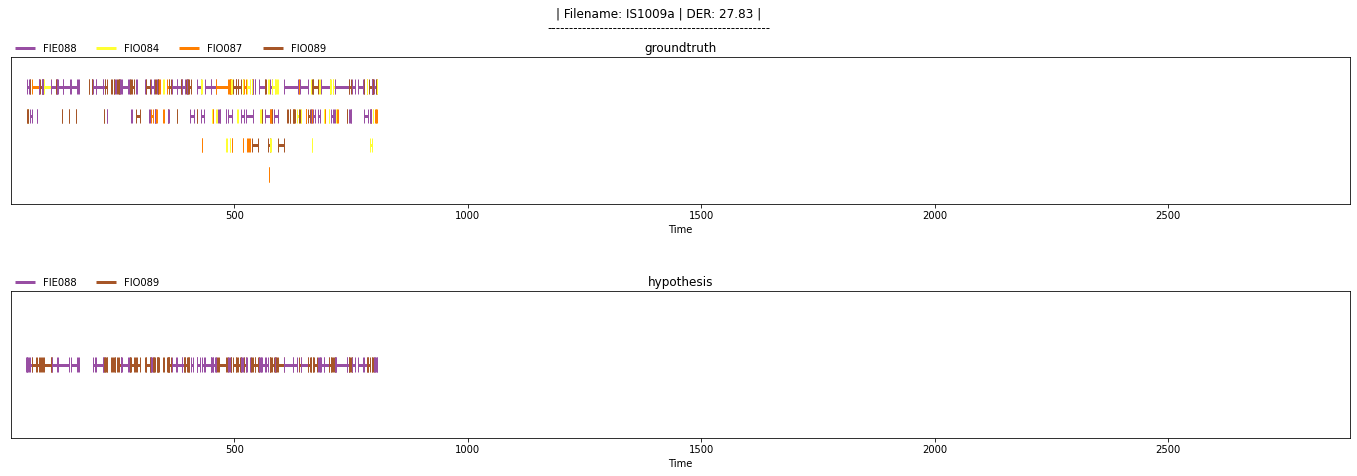

In [18]:
for name in filenames:
    print("\n---------------------------\nDEC\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_dec)
    plt.show()

    print("\n---------------------------\nSpectral\n---------------------------\n")
    plot_annot(name=name, collar=0.25, skip_overlap=True, groundtruth_path=audio_dataset.label_dir, hypothesis_path=hypothesis_dir_spectral)
    plt.show()